处理缺失值

导入包

In [1]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import learning_curve,cross_val_score,KFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from cmath import isnan
import time
sns.set(style='darkgrid', font_scale=1.4)

In [2]:
train_set = pd.read_csv('..\dataset\spaceship-titanic\\train.csv')
test_set = pd.read_csv('..\dataset\spaceship-titanic\\test.csv')
data = pd.read_csv('..\dataset\spaceship-titanic\\data.csv')
print(data)

      PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0         0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1         0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2         0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3         0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4         0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...           ...        ...       ...       ...            ...   ...    ...   
12965     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
12966     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
12967     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
12968     9273_01     Europa     False   D/297/P            NaN   NaN  False   
12969     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

       RoomService  FoodCourt  Shopping

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


年龄从1-79不定，如果直接使用年龄会很难进行判断，将其进行分组，用统计图观察分组效果

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Age_31-50
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Age_18-25
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Age_51+
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Age_31-50
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Age_13-17


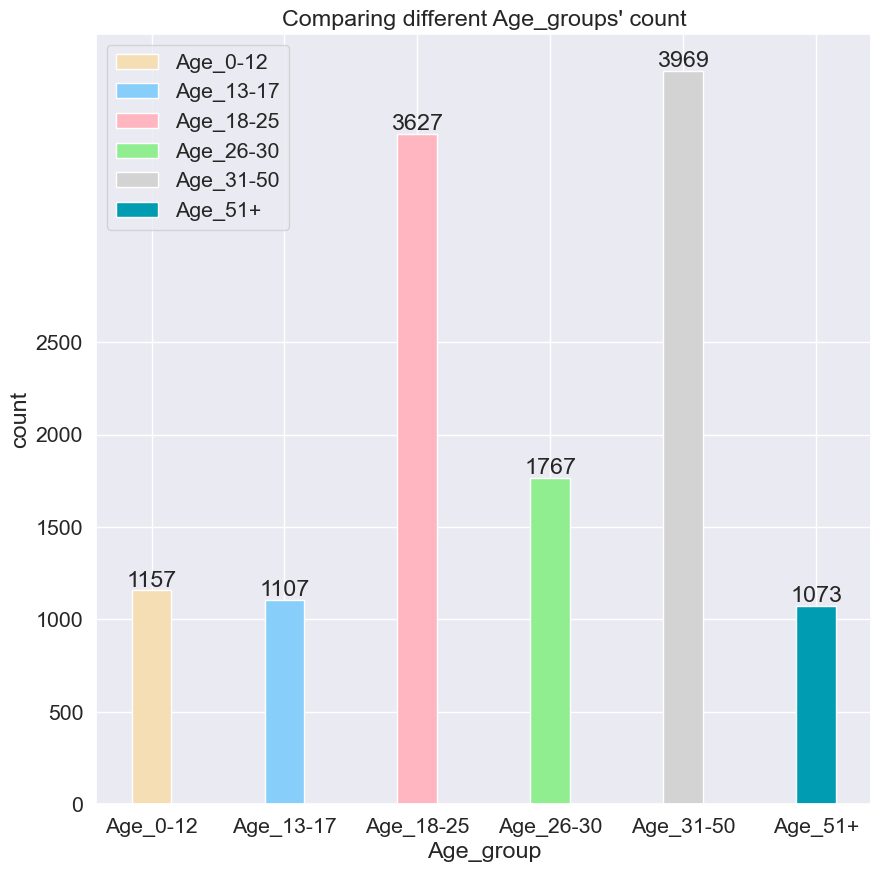

In [4]:
data['Age_group']=np.nan
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

Age_group = {'Age_0-12':0,'Age_13-17':0,'Age_18-25':0,'Age_26-30':0,'Age_31-50':0,'Age_51+':0}

for i in range(0,12970):
    for j in Age_group.keys():
        if data['Age_group'][i] == j:
            Age_group[j] = Age_group[j] + 1

plt.figure(figsize=(10,10))
Age_group_bar_0 = plt.bar("Age_0-12", Age_group['Age_0-12'], width=0.3, color=['#F5DEB3'], label = "Age_0-12");
Age_group_bar_13  = plt.bar("Age_13-17", Age_group['Age_13-17'], width=0.3, color=['#87CEFA'], label = "Age_13-17");
Age_group_bar_18  = plt.bar("Age_18-25", Age_group['Age_18-25'], width=0.3, color=['#FFB6C1'], label = "Age_18-25");
Age_group_bar_26  = plt.bar("Age_26-30", Age_group['Age_26-30'], width=0.3, color=['#90EE90'], label = "Age_26-30");
Age_group_bar_31  = plt.bar("Age_31-50", Age_group['Age_31-50'], width=0.3, color=['#D3D3D3'], label = "Age_31-50");
Age_group_bar_51  = plt.bar("Age_51+", Age_group['Age_51+'], width=0.3, color=['#009db2'], label = "Age_51+");
plt.title("Comparing different Age_groups' count")
plt.xlabel('Age_group')
plt.ylabel('count')
plt.yticks(range(0,3000,500))
plt.legend()

plt.text("Age_0-12", Age_group['Age_0-12'], Age_group['Age_0-12'], ha='center', va='bottom')
plt.text("Age_13-17", Age_group['Age_13-17'], Age_group['Age_13-17'], ha='center', va='bottom')
plt.text("Age_18-25", Age_group['Age_18-25'], Age_group['Age_18-25'], ha='center', va='bottom')
plt.text("Age_26-30", Age_group['Age_26-30'], Age_group['Age_26-30'], ha='center', va='bottom')
plt.text("Age_31-50", Age_group['Age_31-50'], Age_group['Age_31-50'], ha='center', va='bottom')
plt.text("Age_51+", Age_group['Age_51+'], Age_group['Age_51+'], ha='center', va='bottom')

data.head()

Cabin实际上包括三个信息，Deck、Number、Side，将其进行分开

In [5]:
data['Cabin'].fillna('Z/9999/Z', inplace=True)

data['Cabin_Deck'] = data['Cabin'].apply(lambda x: x.split('/')[0])
data['Cabin_Number'] = data['Cabin'].apply(lambda x: x.split('/')[1])
data['Cabin_Side'] = data['Cabin'].apply(lambda x: x.split('/')[2])

for i in range(0,12970):
    data['Cabin_Number'][i] = int(data['Cabin_Number'][i])

data.loc[data['Cabin_Deck']=='Z', 'Cabin_Deck']=np.nan
data.loc[data['Cabin_Number']==9999, 'Cabin_Number']=np.nan
data.loc[data['Cabin_Side']=='Z', 'Cabin_Side']=np.nan
data.loc[data['Cabin']=='Z/9999/Z', 'Cabin']=np.nan

data.head()

C:\Users\1\AppData\Local\Temp\ipykernel_52096\4252752702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cabin_Number'][i] = int(data['Cabin_Number'][i])


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group,Cabin_Deck,Cabin_Number,Cabin_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Age_31-50,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Age_18-25,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Age_51+,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Age_31-50,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Age_13-17,F,1,S


<AxesSubplot: xlabel='Cabin_Deck', ylabel='count'>

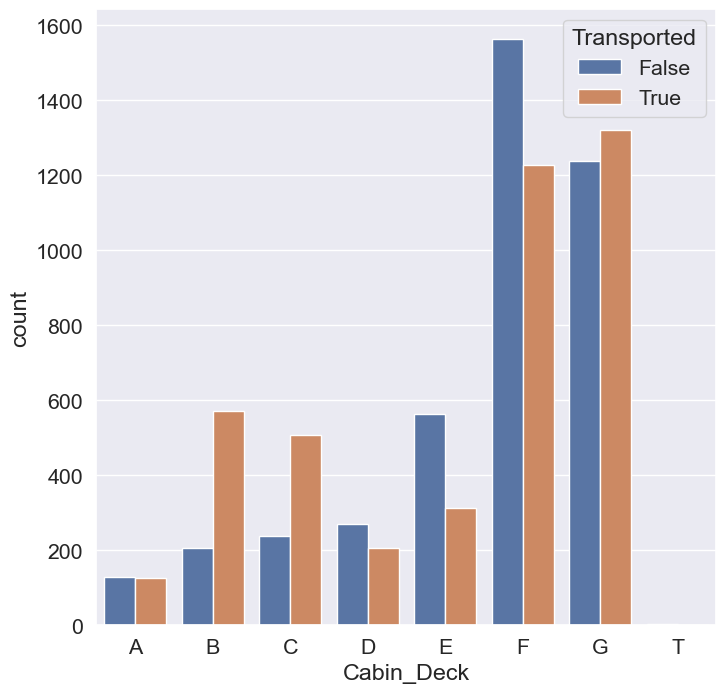

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(data=data, x='Cabin_Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])

<AxesSubplot: xlabel='Cabin_Number', ylabel='count'>

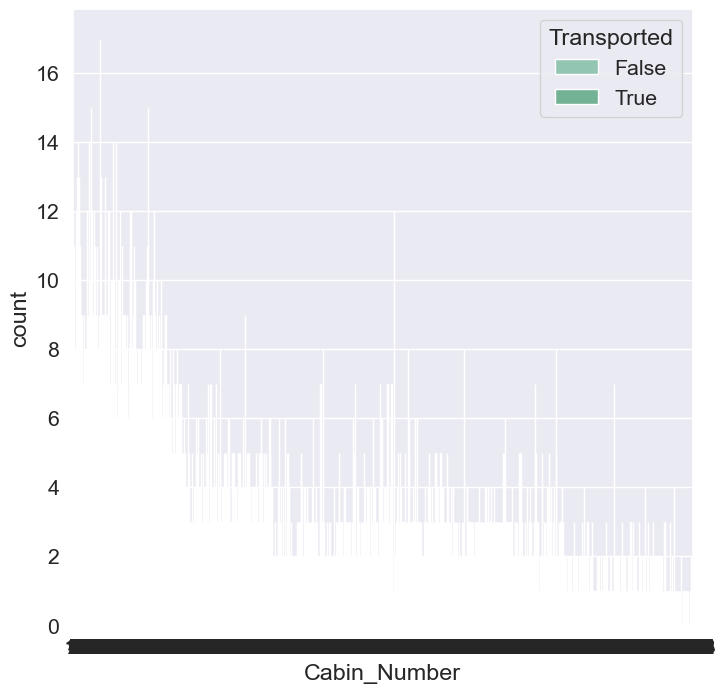

In [7]:
sns.set_palette(sns.color_palette("BuGn_d"))
plt.figure(figsize=(8,8))
sns.countplot(data=data, x='Cabin_Number', hue='Transported')

<AxesSubplot: xlabel='Cabin_Side', ylabel='count'>

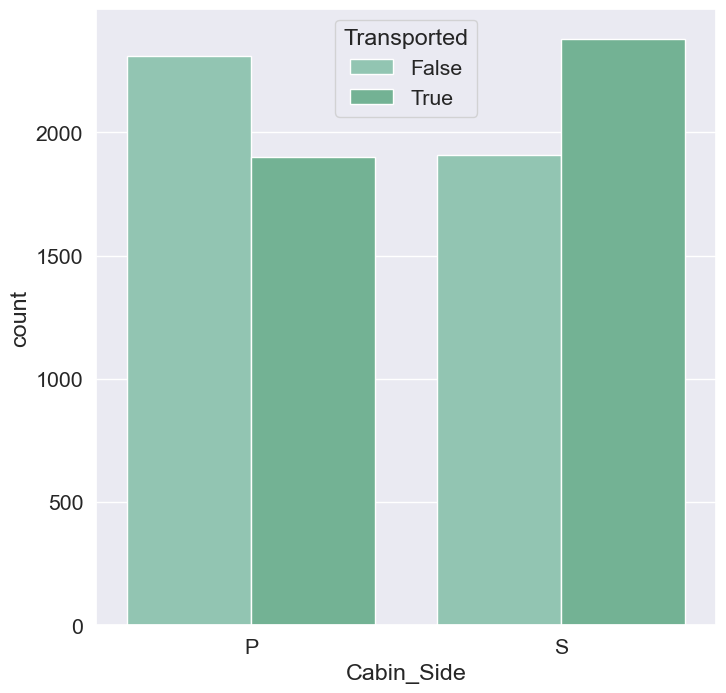

In [8]:
plt.figure(figsize=(8,8))
sns.countplot(data=data, x='Cabin_Side', hue='Transported', order=['P','S'])

每个乘客有唯一的Id。每个Id采用gggg_pp的形式，其中gggg表示乘客正在旅行的Group，pp是他们在Group中的编号。群体中的人通常是家庭成员，但并不总是如此。可以认定的是，Group这个概念对于一起旅行，比如说同一HomePlanet这个的预测较为重要。因此，提取Group这个概念从Passenger_Id中，并且统计GroupSize

In [9]:
data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

data['Group_size'] = data['Group'].map(lambda x: pd.concat([data['Group']]).value_counts()[x])

data['alone'] = (data['Group_size']==1).astype(int)
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Age_group,Cabin_Deck,Cabin_Number,Cabin_Side,Group,Group_size,alone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,Age_31-50,B,0,P,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,Age_18-25,F,0,S,2,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,Age_51+,A,0,S,3,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,Age_31-50,A,0,S,3,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,Age_13-17,F,1,S,4,1,1


Name中应该包括First Name和Last Name，从Last Name可以进行判断是否是同一家族的，这和Group的概念一样，可以判断是否一起旅行。

In [10]:
data['Name'].fillna('Unknown Unknown', inplace=True)

data['LastName'] = data['Name'].str.split().str[-1]
data['FirstName'] = data['Name'].str.split().str[0]

data['Family_size'] = data['LastName'].map(lambda x: pd.concat([data['LastName']]).value_counts()[x])

data.loc[data['LastName']=='Unknown','LastName']=np.nan

data.loc[data['Family_size']>100,'Family_size']=np.nan

data.loc[data['Name']=='Unknown Unknown','Name']=np.nan

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Age_group,Cabin_Deck,Cabin_Number,Cabin_Side,Group,Group_size,alone,LastName,FirstName,Family_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Age_31-50,B,0,P,1,1,1,Ofracculy,Maham,3.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Age_18-25,F,0,S,2,1,1,Vines,Juanna,4.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Age_51+,A,0,S,3,2,0,Susent,Altark,7.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Age_31-50,A,0,S,3,2,0,Susent,Solam,7.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Age_13-17,F,1,S,4,1,1,Santantines,Willy,9.0


In [11]:
HomePlanet_before = data['HomePlanet'].isna().sum()
CryoSleep_before = data['CryoSleep'].isna().sum()
Cabin_before = data['Cabin'].isna().sum()
Destination_before = data['Destination'].isna().sum()
Age_before = data['Age'].isna().sum()
VIP_before = data['VIP'].isna().sum()
RoomService_before = data['RoomService'].isna().sum()
FoodCourt_before = data['FoodCourt'].isna().sum()
ShoppingMall_before = data['ShoppingMall'].isna().sum()
Spa_before = data['Spa'].isna().sum()
VRDeck_before = data['VRDeck'].isna().sum()
Name_before = data['Name'].isna().sum()

print('HomePlanet 处理前缺失值:',HomePlanet_before)
print('CryoSleep 处理前缺失值:',CryoSleep_before)
print('Cabin 处理前缺失值:',Cabin_before)
print('Destination 处理前缺失值:',Destination_before)
print('Age 处理前缺失值:',Age_before)
print('VIP 处理前缺失值:',VIP_before)
print('RoomService 处理前缺失值:',RoomService_before)
print('FoodCourt 处理前缺失值:',FoodCourt_before)
print('ShoppingMall 处理前缺失值:',ShoppingMall_before)
print('Spa 处理前缺失值:',Spa_before)
print('VRDeck 处理前缺失值:',VRDeck_before)
print('Name 处理前缺失值:',Name_before)

HomePlanet 处理前缺失值: 288
CryoSleep 处理前缺失值: 310
Cabin 处理前缺失值: 299
Destination 处理前缺失值: 274
Age 处理前缺失值: 270
VIP 处理前缺失值: 296
RoomService 处理前缺失值: 263
FoodCourt 处理前缺失值: 289
ShoppingMall 处理前缺失值: 306
Spa 处理前缺失值: 284
VRDeck 处理前缺失值: 268
Name 处理前缺失值: 294


观察缺失值，发现虽然只有2%的缺失，但实际上缺失量达到了差不多25%的乘客都至少有一列信息是缺失的，不采用丢弃的方法，采用替换的方法，同时观察不同数据之间的关系，来填补缺失值

<AxesSubplot: >

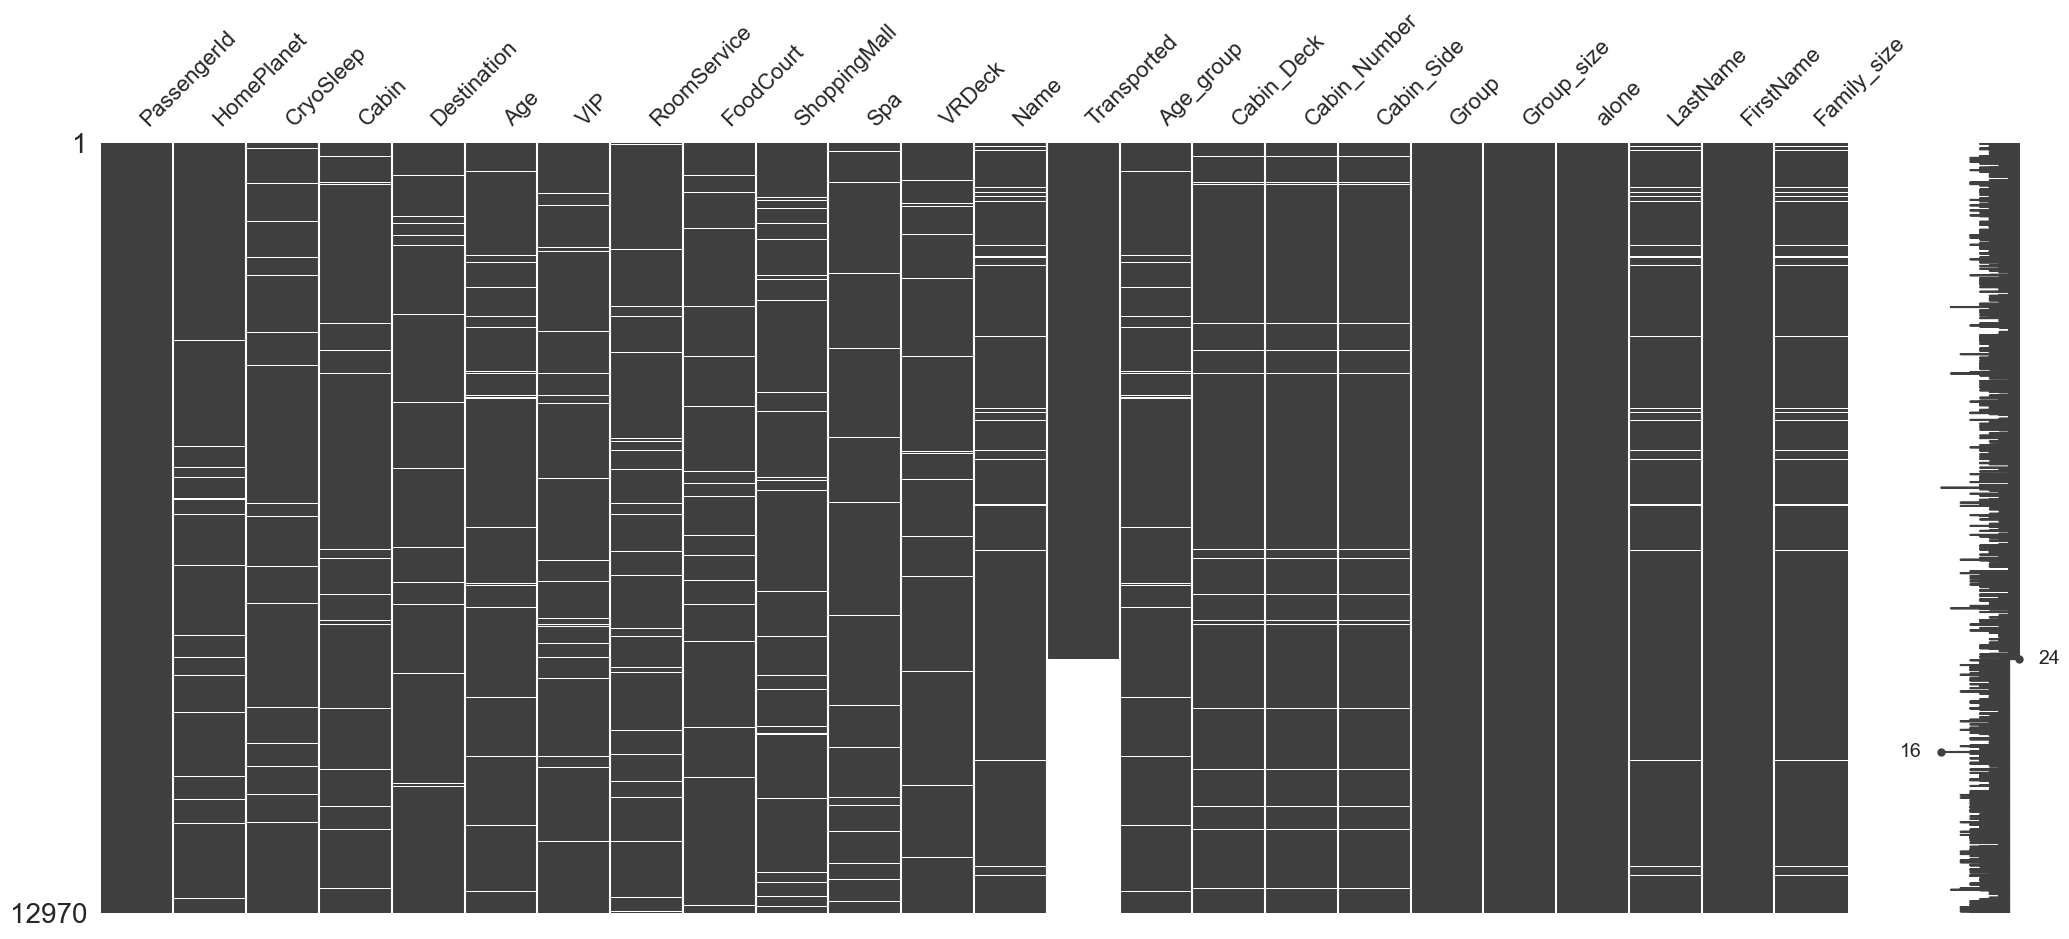

In [12]:
msno.matrix(data)

<AxesSubplot: >

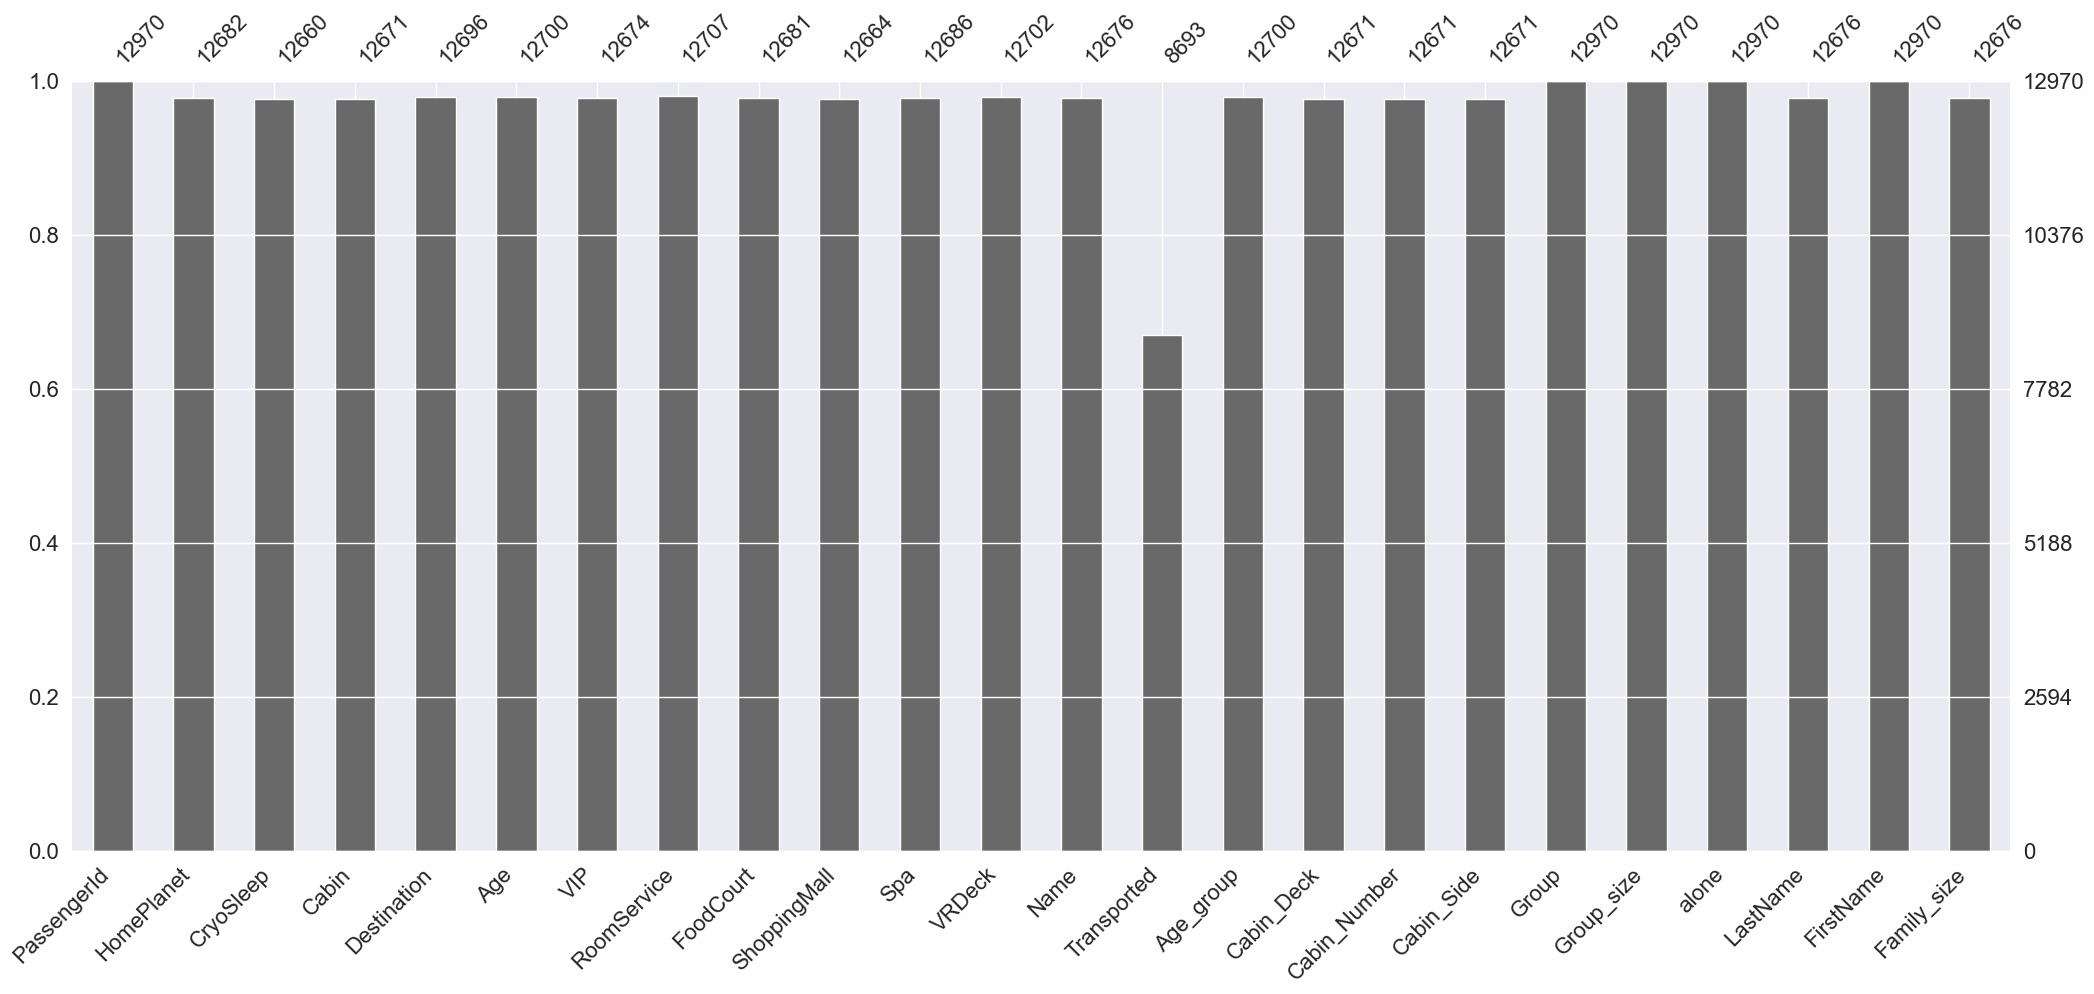

In [13]:
msno.bar(data)

处理HomePlanet

已知同一Group很有可能一起旅行，利用Group处理HomePlanet

In [14]:
Group_HomePlanet = data.groupby(['Group','HomePlanet'])['HomePlanet']
Group_HomePlanet = Group_HomePlanet.size().unstack().fillna(0)#行转列，并且进行nan转为0的填充
Group_HomePlanet.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


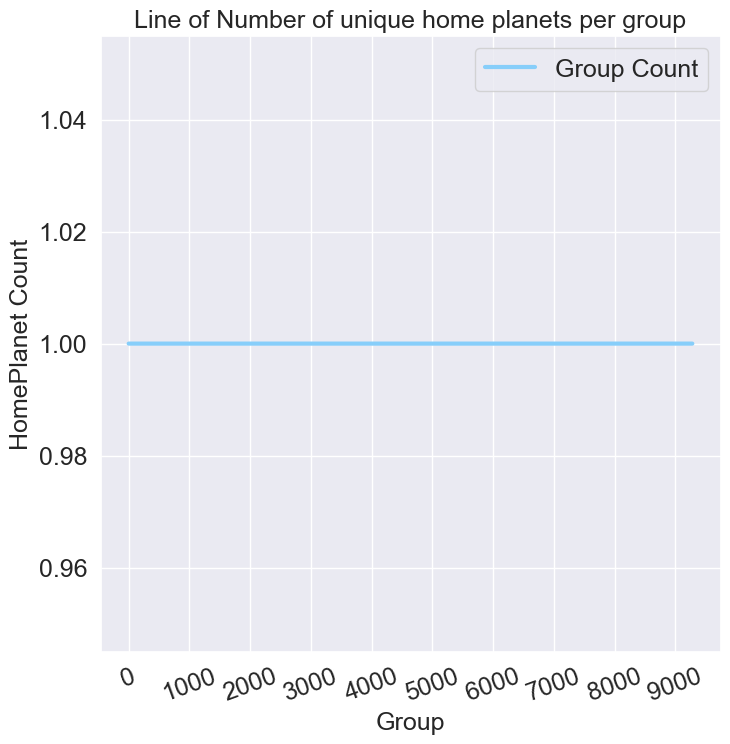

In [15]:
plt.figure(figsize=(8,8))
Group_HomePlanet_dic = dict((Group_HomePlanet>0).sum(axis=1))

plt.plot(Group_HomePlanet_dic.keys(), Group_HomePlanet_dic.values(), color='#87CEFA', label='Group Count', linewidth=3.0)
plt.xticks((0,1000,2000,3000,4000,5000,6000,7000,8000,9000), (0,1000,2000,3000,4000,5000,6000,7000,8000,9000),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'Group', fontsize=18)
plt.ylabel(u'HomePlanet Count', fontsize=18)
plt.title(u'Line of Number of unique home planets per group', fontsize=18)
plt.legend(fontsize=18)

这表明同一小组的每个人都来自同一个星球，因此可以根据小组的情况来填补缺少的HomePlanet.

In [16]:
HomePlanet_before = data['HomePlanet'].isna().sum()

GHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(Group_HomePlanet.index)].index

data.loc[GHP_index,'HomePlanet'] = data.iloc[GHP_index,:]['Group'].map(lambda x: Group_HomePlanet.idxmax(axis=1)[x])

print('HomePlanet 处理前缺失值:',HomePlanet_before)
print('HomePlanet 处理后缺失值:',data['HomePlanet'].isna().sum())

HomePlanet 处理前缺失值: 288
HomePlanet 处理后缺失值: 157


观察后发现Cabin_Deck与HomePlanet有关系，利用Cabin_Deck处理HomePlanet

<AxesSubplot: xlabel='Cabin_Deck', ylabel='HomePlanet'>

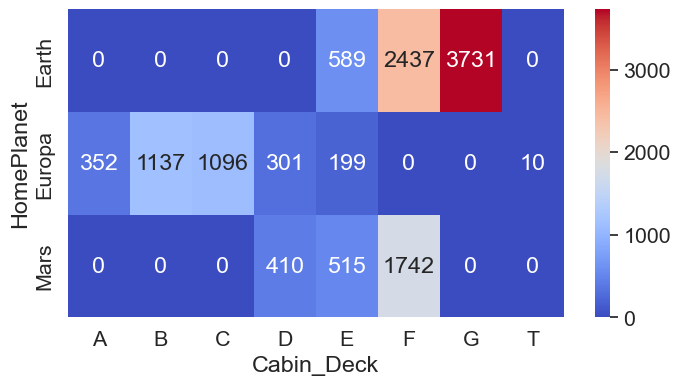

In [17]:
Cabin_Deck_HomePlanet = data.groupby(['Cabin_Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)#按照Cabin_Deck和HomePlanet进行分组，行转列，填缺失值

plt.figure(figsize=(8,4))
sns.heatmap(Cabin_Deck_HomePlanet.T, annot=True, fmt='g', cmap='coolwarm')

乘客的桌子：A, B, C , T 母星：Europa.
乘客的桌子：G 母星：Earth.
乘客的桌子：D, E, F 母星：复杂

In [18]:
HomePlanet_before = data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_Deck']=='G'), 'HomePlanet']='Earth'

print('HomePlanet 处理前缺失值:',HomePlanet_before)
print('HomePlanet 处理后缺失值:',data['HomePlanet'].isna().sum())

HomePlanet 处理前缺失值: 157
HomePlanet 处理后缺失值: 94


利用LastName处理HomePlanet，与Group同理

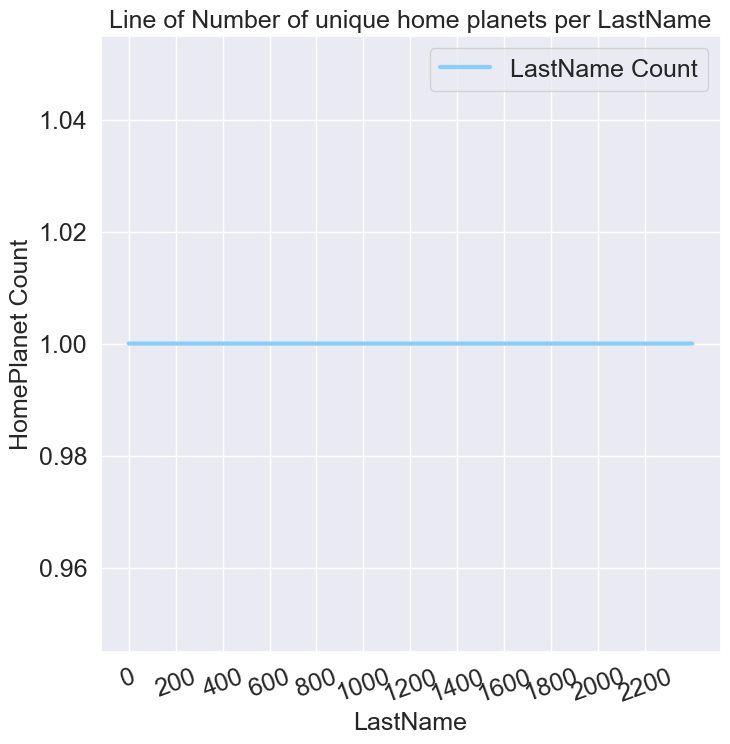

In [19]:
LastName_HomePlanet = data.groupby(['LastName','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(8,8))
LastName_HomePlanet_dic = dict((LastName_HomePlanet>0).sum(axis=1))

plt.plot(LastName_HomePlanet_dic.keys(), LastName_HomePlanet_dic.values(), color='#87CEFA', label='LastName Count', linewidth=3.0)
plt.xticks((0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200), (0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'LastName', fontsize=18)
plt.ylabel(u'HomePlanet Count', fontsize=18)
plt.title(u'Line of Number of unique home planets per LastName', fontsize=18)
plt.legend(fontsize=18)

同一个LastName来自同一个HomePlanet

In [20]:
HomePlanet_before = data['HomePlanet'].isna().sum()

LastName_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['LastName']).isin(LastName_HomePlanet.index)].index

data.loc[LastName_index,'HomePlanet'] = data.iloc[LastName_index,:]['LastName'].map(lambda x: LastName_HomePlanet.idxmax(axis=1)[x])

print('HomePlanet 处理前缺失值:',HomePlanet_before)
print('HomePlanet 处理后缺失值:',data['HomePlanet'].isna().sum())

HomePlanet 处理前缺失值: 94
HomePlanet 处理后缺失值: 10


查看剩下信息，可发现Deck要么D要么F，回去查看Deck与HomePlanet关系

In [21]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination','Cabin_Deck','LastName','Group']]

,PassengerId,HomePlanet,Destination,Cabin_Deck,LastName,Group
2274,2443_01,NaN,TRAPPIST-1e,D,NaN,2443
2631,2817_01,NaN,TRAPPIST-1e,F,Sutty,2817
3091,3331_01,NaN,TRAPPIST-1e,F,NaN,3331
4548,4840_01,NaN,TRAPPIST-1e,F,NaN,4840
5762,6108_01,NaN,TRAPPIST-1e,F,NaN,6108
8969,0616_01,NaN,TRAPPIST-1e,E,Spriney,616
10583,4052_01,NaN,TRAPPIST-1e,D,Coneveseng,4052
11913,7065_01,NaN,TRAPPIST-1e,E,Maltorted,7065
12551,8435_01,NaN,TRAPPIST-1e,F,NaN,8435
12725,8775_01,NaN,TRAPPIST-1e,D,Maltorted,8775


发现Destination都是TR

<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

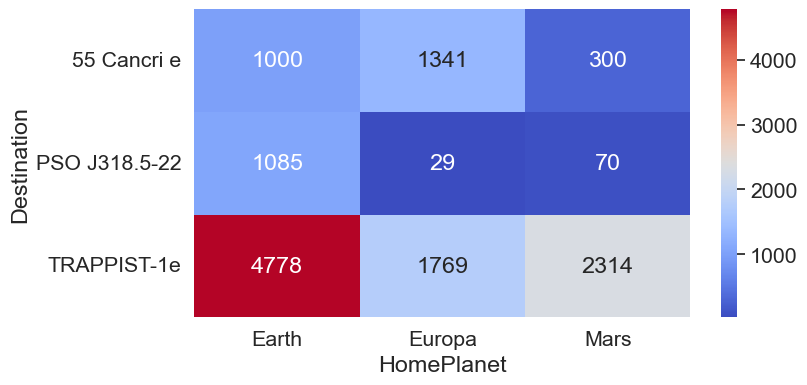

In [22]:
HomePlanet_Destination = data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(HomePlanet_Destination.T, annot=True, fmt='g', cmap='coolwarm')

前往TR的人大多数来自Earth，但是桌子为D的人来自Mars和Europa（Mars比例高），而桌子为F的人来自Earth和Mars（Earth比例高）

In [23]:
HomePlanet_before = data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_Deck']=='D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_Deck']=='D'), 'HomePlanet'] = 'Mars'

print('HomePlanet 处理前缺失值:',HomePlanet_before)
print('HomePlanet 处理后缺失值:',data['HomePlanet'].isna().sum())

HomePlanet 处理前缺失值: 10
HomePlanet 处理后缺失值: 0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  Age_group     12700 non-null  object 
 15  Cabin_Deck    12671 non-null  object 
 16  Cabin_Number  12671 non-null  object 
 17  Cabin_Side    12671 non-null  object 
 18  Group         12970 non-nu

处理Destination

In [25]:
Group_Destination = data.groupby(['Group','Destination'])['Destination'].size().unstack().fillna(0)
Group_Destination.head()

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Group,,,
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,2.0
4,0.0,0.0,1.0
5,0.0,1.0,0.0


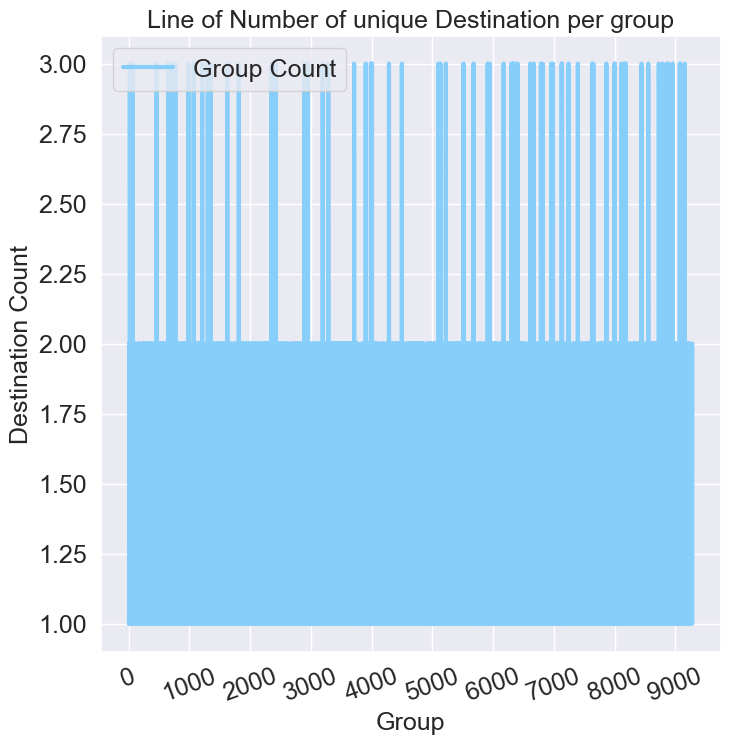

In [26]:
plt.figure(figsize=(8,8))
Group_Destination_dic = dict((Group_Destination>0).sum(axis=1))

plt.plot(Group_Destination_dic.keys(), Group_Destination_dic.values(), color='#87CEFA', label='Group Count', linewidth=3.0)
plt.xticks((0,1000,2000,3000,4000,5000,6000,7000,8000,9000), (0,1000,2000,3000,4000,5000,6000,7000,8000,9000),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'Group', fontsize=18)
plt.ylabel(u'Destination Count', fontsize=18)
plt.title(u'Line of Number of unique Destination per group', fontsize=18)
plt.legend(fontsize=18)

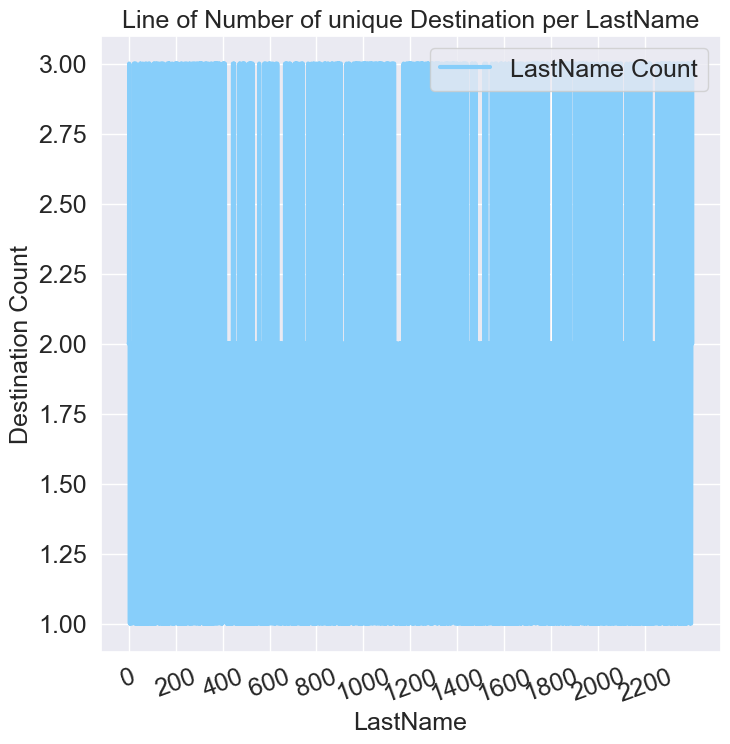

In [27]:
LastName_Destination = data.groupby(['LastName','Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(8,8))
LastName_Destination_dic = dict((LastName_Destination>0).sum(axis=1))

plt.plot(LastName_Destination_dic.keys(), LastName_Destination_dic.values(), color='#87CEFA', label='LastName Count', linewidth=3.0)
plt.xticks((0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200), (0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'LastName', fontsize=18)
plt.ylabel(u'Destination Count', fontsize=18)
plt.title(u'Line of Number of unique Destination per LastName', fontsize=18)
plt.legend(fontsize=18)

发现Destination与Group和LastName没有什么关系，重新寻找，利用Cabin_Deck

<AxesSubplot: xlabel='Cabin_Deck', ylabel='Destination'>

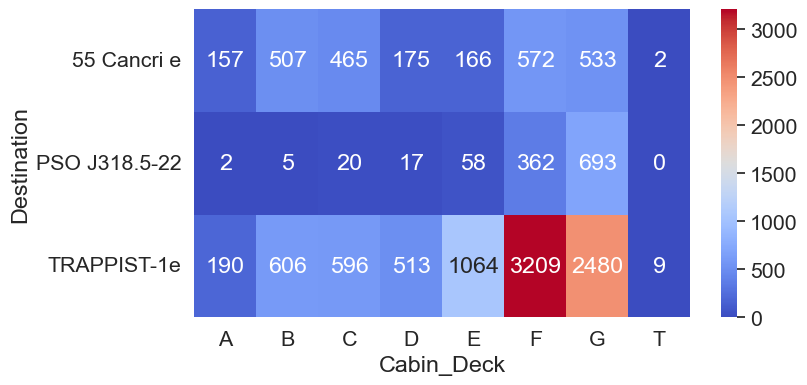

In [28]:
Cabin_Deck_Destination = data.groupby(['Cabin_Deck','Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(Cabin_Deck_Destination.T, annot=True, fmt='g', cmap='coolwarm')

利用众数思想

In [29]:
Destination_before = data['Destination'].isna().sum()

data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='A'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='B'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='C'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='D'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='E'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='F'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='G'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck']=='T'), 'Destination']='TRAPPIST-1e'
data.loc[(data['Destination'].isna()) & (data['Cabin_Deck'].isna()), 'Destination']='TRAPPIST-1e'

print('Destination 处理前缺失值:',Destination_before)
print('Destination 处理后缺失值:',data['Destination'].isna().sum())

Destination 处理前缺失值: 274
Destination 处理后缺失值: 0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  Age_group     12700 non-null  object 
 15  Cabin_Deck    12671 non-null  object 
 16  Cabin_Number  12671 non-null  object 
 17  Cabin_Side    12671 non-null  object 
 18  Group         12970 non-nu

LastName填充，从之前的信息可以得知，LastName和Group_size有很强的相关性

将Group_size>1，也就是同一组旅行的人超过一个人的，观察他们的LastName是否相同

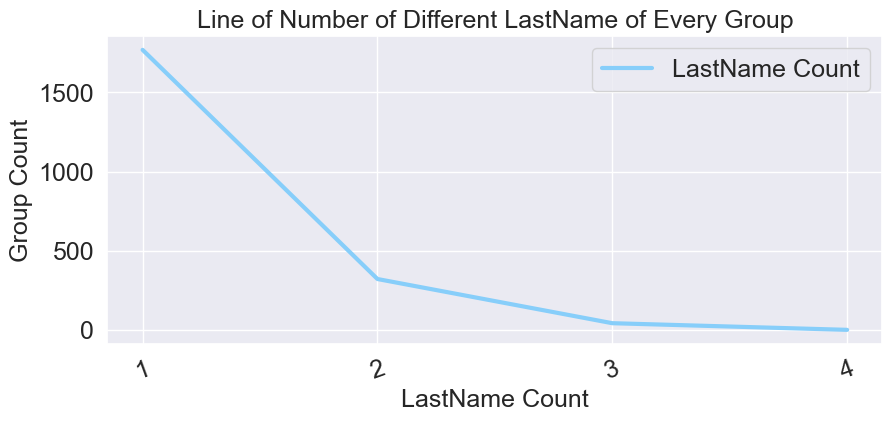

In [31]:
LastName_GroupSize = data[data['Group_size']>1].groupby(['Group','LastName'])['LastName'].size().unstack().fillna(0)

plt.figure(figsize=(10,4))
LastName_GroupSize_dic = dict((LastName_GroupSize>0).sum(axis=1))

difGroup_LastNameCount = {1:0,2:0,3:0,4:0}
for i in LastName_GroupSize_dic.values():
    difGroup_LastNameCount[i] = difGroup_LastNameCount[i] + 1

plt.plot(difGroup_LastNameCount.keys(), difGroup_LastNameCount.values(), color='#87CEFA', label='LastName Count', linewidth=3.0)
plt.xticks((1,2,3,4), (1,2,3,4),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'LastName Count', fontsize=18)
plt.ylabel(u'Group Count', fontsize=18)
plt.title(u'Line of Number of Different LastName of Every Group', fontsize=18)
plt.legend(fontsize=18)

超过80%的Group里面只有一种LastName，所以对于同一Group的可以赋予同一LastName

In [32]:
LastName_before = data['LastName'].isna().sum()

GroupSize_LastName_index = data[data['LastName'].isna()][(data[data['LastName'].isna()]['Group']).isin(LastName_GroupSize.index)].index

data.loc[GroupSize_LastName_index,'LastName'] = data.iloc[GroupSize_LastName_index,:]['Group'].map(lambda x: LastName_GroupSize.idxmax(axis=1)[x])

print('LastName 处理前缺失值:',LastName_before)
print('LastName 处理后缺失值:',data['LastName'].isna().sum())

LastName 处理前缺失值: 294
LastName 处理后缺失值: 155


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  Age_group     12700 non-null  object 
 15  Cabin_Deck    12671 non-null  object 
 16  Cabin_Number  12671 non-null  object 
 17  Cabin_Side    12671 non-null  object 
 18  Group         12970 non-nu

Cabin和Group

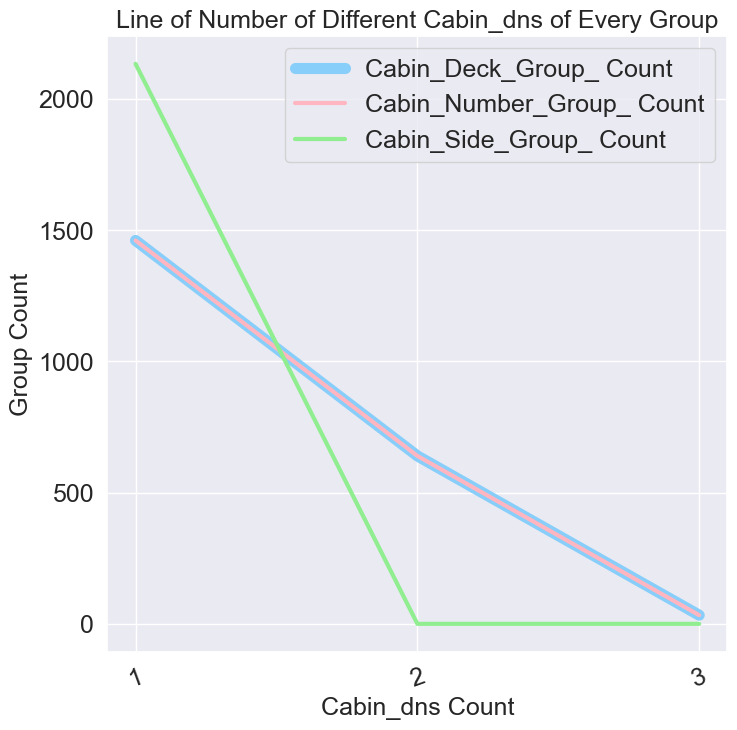

In [34]:
Cabin_Deck_Group_size = data[data['Group_size']>1].groupby(['Group','Cabin_Deck'])['Cabin_Deck'].size().unstack().fillna(0)
Cabin_Number_Group_size = data[data['Group_size']>1].groupby(['Group','Cabin_Number'])['Cabin_Number'].size().unstack().fillna(0)
Cabin_Side_Group_size = data[data['Group_size']>1].groupby(['Group','Cabin_Side'])['Cabin_Side'].size().unstack().fillna(0)

Cabin_Deck_Group_size_dic = {1:0,2:0,3:0}
Cabin_Number_Group_size_dic = {1:0,2:0,3:0}
Cabin_Side_Group_size_dic = {1:0,2:0,3:0}

for i in (Cabin_Deck_Group_size>0).sum(axis=1):
    Cabin_Deck_Group_size_dic[i] = Cabin_Deck_Group_size_dic[i] + 1

for i in (Cabin_Deck_Group_size>0).sum(axis=1):
    Cabin_Number_Group_size_dic[i] = Cabin_Number_Group_size_dic[i] + 1

for i in (Cabin_Side_Group_size>0).sum(axis=1):
    Cabin_Side_Group_size_dic[i] = Cabin_Side_Group_size_dic[i] + 1

plt.figure(figsize=(8,8))
plt.plot(Cabin_Deck_Group_size_dic.keys(), Cabin_Deck_Group_size_dic.values(), color='#87CEFA', label='Cabin_Deck_Group_ Count', linewidth=8.0)
plt.plot(Cabin_Number_Group_size_dic.keys(), Cabin_Number_Group_size_dic.values(), color='#FFB6C1', label='Cabin_Number_Group_ Count', linewidth=3.0)
plt.plot(Cabin_Side_Group_size_dic.keys(), Cabin_Side_Group_size_dic.values(), color='#90EE90', label='Cabin_Side_Group_ Count', linewidth=3.0)

plt.xticks((1,2,3), (1,2,3),fontsize=18, rotation=20)
plt.yticks(fontsize=18)
 
# 添加x轴和y轴标签
plt.xlabel(u'Cabin_dns Count', fontsize=18)
plt.ylabel(u'Group Count', fontsize=18)
plt.title(u'Line of Number of Different Cabin_dns of Every Group', fontsize=18)
plt.legend(fontsize=18)

同一个Group的都在同一个Side上，虽然Deck和Number没有那么好的相关性，但是也还可以

In [35]:
Cabin_Side_before = data['Cabin_Side'].isna().sum()

Group_Cabin_Side_Index = data[data['Cabin_Side'].isna()][(data[data['Cabin_Side'].isna()]['Group']).isin(Cabin_Side_Group_size.index)].index

data.loc[Group_Cabin_Side_Index,'Cabin_Side'] = data.iloc[Group_Cabin_Side_Index,:]['Group'].map(lambda x: Cabin_Side_Group_size.idxmax(axis=1)[x])

print('Cabin_Side 处理前缺失值:',Cabin_Side_before)
print('Cabin_Side 处理后缺失值:',data['Cabin_Side'].isna().sum())

Cabin_Side 处理前缺失值: 299
Cabin_Side 处理后缺失值: 162


Cabin_Side和LastName

In [36]:
# Cabin_Side_LastName = data[data['Group_size']>1].groupby(['LastName','Cabin_Side'])['Cabin_Side'].size().unstack().fillna(0)

# Cabin_Side_LastName['Rate'] = Cabin_Side_LastName['P']/(Cabin_Side_LastName['P'] + Cabin_Side_LastName['S'])

# plt.figure(figsize=(10,4))
# sns.histplot(Cabin_Side_LastName['Rate'], binwidth=0.05)
# plt.title('Ratio of cabin side by LastName')

可以看见大部分同一姓氏的人住的都是同一个Cabin_Side，p或s

In [37]:
# Cabin_Side_before = data['Cabin_Side'].isna().sum()

# Cabin_Side_LastName.drop('Rate', axis=1, inplace=True)

# Cabin_Side_LastName_Index = data[data['Cabin_Side'].isna()][(data[data['Cabin_Side'].isna()]['LastName']).isin(Cabin_Side_LastName.index)].index

# data.loc[Cabin_Side_LastName_Index ,'Cabin_Side'] = data.iloc[Cabin_Side_LastName_Index ,:]['LastName'].map(lambda x: Cabin_Side_LastName.idxmax(axis=1)[x])

# print('Cabin_side 处理前缺失值:',Cabin_Side_before)
# print('Cabin_side 处理后缺失值:',data['Cabin_Side'].isna().sum())

In [38]:
data['Cabin_Side'].value_counts()

S    6454
P    6354
Name: Cabin_Side, dtype: int64

添补完发现太相近了，random吧。。。。

In [39]:
Cabin_Side_before = data['Cabin_Side'].isna().sum()

list1 = ['P','S']
data.loc[data['Cabin_Side'].isna(),'Cabin_Side'] = random.choice(list1)

print('Cabin_side 处理前缺失值:',Cabin_Side_before)
print('Cabin_side 处理后缺失值:',data['Cabin_Side'].isna().sum())

Cabin_side 处理前缺失值: 162
Cabin_side 处理后缺失值: 0


超过70%的Cabin_Deck上只有一个Group，可认为同一Group的坐在同一Cabin_Deck上

In [40]:
Cabin_Deck_before = data['Cabin_Deck'].isna().sum()

Group_Cabin_Deck_index = data[data['Cabin_Deck'].isna()][(data[data['Cabin_Deck'].isna()]['Group']).isin(Cabin_Deck_Group_size.index)].index

data.loc[Group_Cabin_Deck_index,'Cabin_Deck'] = data.iloc[Group_Cabin_Deck_index,:]['Group'].map(lambda x: Cabin_Deck_Group_size.idxmax(axis=1)[x])

print('Cabin_Deck 处理前缺失值:',Cabin_Deck_before)
print('Cabin_Deck 处理后缺失值:',data['Cabin_Deck'].isna().sum())

Cabin_Deck 处理前缺失值: 299
Cabin_Deck 处理后缺失值: 162


由之前的信息得知，Cabin_Deck和HomePlanet有较强的可分性

In [41]:
data.groupby(['HomePlanet','Cabin_Deck'])['Cabin_Deck'].size().unstack().fillna(0)

Cabin_Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.0,0.0,0.0,0.0,601.0,2496.0,3821.0,0.0
Europa,361.0,1161.0,1122.0,309.0,204.0,0.0,0.0,11.0
Mars,0.0,0.0,0.0,421.0,529.0,1772.0,0.0,0.0


来自Mars的大多数坐F，来自Earth的大多数坐F或G，来自Europa的大多数坐B或C

In [42]:
Cabin_Deck_before = data['Cabin_Deck'].isna().sum()

list_Earth = ['F','G']
list_Europa = ['B','C']

data.loc[(data['Cabin_Deck'].isna()) & (data['HomePlanet']=='Mars'), 'Cabin_Deck'] = 'F'
data.loc[(data['Cabin_Deck'].isna()) & (data['HomePlanet']=='Europa'), 'Cabin_Deck'] = random.choice(list_Earth)
data.loc[(data['Cabin_Deck'].isna()) & (data['HomePlanet']=='Earth'), 'Cabin_Deck'] = random.choice(list_Europa)

print('Cabin_Deck 处理前缺失值:',Cabin_Deck_before)
print('Cabin_Deck 处理后缺失值:',data['Cabin_Deck'].isna().sum())

Cabin_Deck 处理前缺失值: 162
Cabin_Deck 处理后缺失值: 0


Cabin_Number 随机数，因为没什么关系

In [43]:
Cabin_Number_before = data['VIP'].isna().sum()
list_Cabin_Number = []
for i in range(0,12970):
    if type(data['Cabin_Number'][i]) != float:
        list_Cabin_Number.append(data['Cabin_Number'][i])

list_Cabin_Number = list(set(list_Cabin_Number))

for i in range(0,12970):
    if type(data['Cabin_Number'][i]) == float:
        data['Cabin_Number'][i] = random.choice(list_Cabin_Number)

print('VIP 处理前缺失值:',Cabin_Number_before)
print('VIP 处理后缺失值:',data['Cabin_Number'].isna().sum())

VIP 处理前缺失值: 296
VIP 处理后缺失值: 0


C:\Users\1\AppData\Local\Temp\ipykernel_52096\2125972602.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cabin_Number'][i] = random.choice(list_Cabin_Number)


VIP，众数

In [44]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [45]:
VIP_before = data['VIP'].isna().sum()

data.loc[data['VIP'].isna(),'VIP'] = False

print('VIP 处理前缺失值:',VIP_before)
print('VIP 处理后缺失值:',data['VIP'].isna().sum())

VIP 处理前缺失值: 296
VIP 处理后缺失值: 0


Age，Age应该和很多因素相关，比如说消费，然后是否一个人旅行，身边一起旅行的人，而身边一起旅行的人又会涉及到如座位，母星等信息

In [46]:
Expenditure_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
data['Expenditure'] = data[Expenditure_features].sum(axis=1)
data['spending'] = (data['Expenditure']!=0).astype(int)

In [47]:
data.groupby(['HomePlanet','spending','alone','Cabin_Deck'])['Age'].median().unstack().fillna(0)

Cabin_Deck                    A     B     C     D     E     F     G     T
HomePlanet spending alone                                                
Earth      0        0       0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                    1       0.0  21.0   0.0   0.0  21.0  25.0  23.0   0.0
           1        0       0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                    1       0.0  25.0   0.0   0.0  25.0  24.0  26.0   0.0
Europa     0        0      30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                    1      37.5  34.0  34.5  31.0  33.0  36.5   0.0   0.0
           1        0      35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                    1      35.0  36.0  35.5  34.0  35.0  34.0   0.0  35.0
Mars       0        0       0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                    1       0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0
           1        0       0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                    1       0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0

In [48]:
Age_before = data[Expenditure_features].isna().sum().sum()

data.loc[data['Age'].isna(),'Age'] = data.groupby(['HomePlanet','spending','alone','Cabin_Deck'])['Age'].transform(lambda x: x.fillna(x.median()))[data.loc[data['Age'].isna(),'Age'].index]

print('Age 处理前缺失值:',Age_before)
print('Age 处理后缺失值:',data['Age'].isna().sum())

Age 处理前缺失值: 1410
Age 处理后缺失值: 0


CryoSleep，按照常理来说，是否休眠，看的就是是否有花费

In [49]:
data.groupby(['spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
spending,,
0,740.0,4581.0
1,7339.0,0.0


In [50]:
CryoSleep_before = data['CryoSleep'].isna().sum()

for i in range(0,12970):
    if type(data['CryoSleep'][i]) != bool:
        if data['spending'][i] == 1:
            data['CryoSleep'][i] = False
        elif data['spending'][i] == 0:
            data['CryoSleep'][i] = True

print('CryoSleep 处理前缺失值:',CryoSleep_before)
print('CryoSleep 处理后缺失值:',data['CryoSleep'].isna().sum())

CryoSleep 处理前缺失值: 310
CryoSleep 处理后缺失值: 0


C:\Users\1\AppData\Local\Temp\ipykernel_52096\1603476345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CryoSleep'][i] = True
C:\Users\1\AppData\Local\Temp\ipykernel_52096\1603476345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CryoSleep'][i] = False


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12970 non-null  float64
 6   VIP           12970 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  Age_group     12700 non-null  object 
 15  Cabin_Deck    12970 non-null  object 
 16  Cabin_Number  12970 non-null  object 
 17  Cabin_Side    12970 non-null  object 
 18  Group         12970 non-nu

Expenditure和CryoSleep 因为处于休眠状态下，花费为0

In [52]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True, Expenditure_features].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [53]:
Expenditure_before = data[Expenditure_features].isna().sum().sum()

for i in Expenditure_features:
    for j in range(0,12970):
        if isnan(data[i][j]) and data['CryoSleep'][j]==True:
            data[i][j]=0

print('Expenditure 处理前缺失值:',Expenditure_before)
print('Expenditure 处理后缺失值:',data[Expenditure_features].isna().sum().sum())

C:\Users\1\AppData\Local\Temp\ipykernel_52096\1874515241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][j]=0


Expenditure 处理前缺失值: 1410
Expenditure 处理后缺失值: 866


In [54]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            299
Destination        0
Age                0
VIP                0
RoomService      170
FoodCourt        179
ShoppingMall     172
Spa              173
VRDeck           172
Name             294
Transported     4277
Age_group        270
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName         155
FirstName          0
Family_size      294
Expenditure        0
spending           0
dtype: int64

剩下的花费用均值代替

In [55]:
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

In [56]:
data.groupby(['HomePlanet','alone','Age_group'])['FoodCourt'].mean().unstack().fillna(0)

Age_group         Age_0-12   Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet alone                                                                
Earth      0           0.0  199.766816   145.031955   204.743590   134.231111   
           1           0.0  159.775281   158.426151   164.902482   172.359038   
Europa     0           0.0  237.756410  1133.276882  1548.449761  1719.286895   
           1           0.0    0.000000  1194.411290  1609.093333  1703.157143   
Mars       0           0.0   24.198198    57.492997    50.564972    92.884211   
           1           0.0   25.730159    45.746702    78.833962    62.134357   

Age_group             Age_51+  
HomePlanet alone               
Earth      0       209.061404  
           1       174.779180  
Europa     0      1262.778243  
           1      1762.019737  
Mars       0        25.482143  
           1        52.520661

In [57]:
data.groupby(['HomePlanet','alone','Age_group'])['RoomService'].mean().unstack().fillna(0)

Age_group         Age_0-12   Age_13-17   Age_18-25   Age_26-30   Age_31-50  \
HomePlanet alone                                                             
Earth      0           0.0  133.455357  152.152830  173.187192  181.176600   
           1           0.0  148.234733  149.941301  148.726631  172.305833   
Europa     0           0.0   69.314103   91.542781  118.699284  191.644970   
           1           0.0    0.000000   83.776000  196.558036  133.568100   
Mars       0           0.0  714.509091  559.915730  572.265193  629.338624   
           1           0.0  830.718750  538.783069  556.852830  550.973282   

Age_group            Age_51+  
HomePlanet alone              
Earth      0      127.495652  
           1      127.498452  
Europa     0      135.717842  
           1       63.483221  
Mars       0      702.232143  
           1      629.048780

In [58]:
data.groupby(['HomePlanet','alone','Age_group'])['ShoppingMall'].mean().unstack().fillna(0)

Age_group         Age_0-12   Age_13-17   Age_18-25   Age_26-30   Age_31-50  \
HomePlanet alone                                                             
Earth      0           0.0  176.800000  144.891182  148.138614  144.803097   
           1           0.0  118.410208  169.693038  152.728723  135.566335   
Europa     0           0.0  283.664516   80.447439  184.270983  103.966587   
           1           0.0    0.000000  195.396825  124.442478  195.295900   
Mars       0           0.0  317.252252  381.352273  469.477778  261.464000   
           1           0.0  696.723077  313.328084  304.951128  376.418738   

Age_group            Age_51+  
HomePlanet alone              
Earth      0      131.175439  
           1      160.358025  
Europa     0       89.457627  
           1       88.798658  
Mars       0      388.178571  
           1      235.088710

In [59]:
data.groupby(['HomePlanet','alone','Age_group'])['Spa'].mean().unstack().fillna(0)

Age_group         Age_0-12   Age_13-17   Age_18-25   Age_26-30    Age_31-50  \
HomePlanet alone                                                              
Earth      0           0.0  101.553571  190.657197  177.756219   142.918322   
           1           0.0  125.587121  159.849286  173.754850   167.427977   
Europa     0           0.0  292.941558  571.554667  795.720096  1032.127962   
           1           0.0    0.000000  560.217742  740.224670   983.067979   
Mars       0           0.0  112.481818  132.782730  118.838889   115.850667   
           1           0.0   45.615385  134.326316  120.651685    81.551923   

Age_group             Age_51+  
HomePlanet alone               
Earth      0       113.017699  
           1       192.867284  
Europa     0       997.659664  
           1      1106.768212  
Mars       0       194.491071  
           1       130.704918

In [60]:
data.groupby(['HomePlanet','alone','Age_group'])['VRDeck'].mean().unstack().fillna(0)

Age_group         Age_0-12   Age_13-17   Age_18-25    Age_26-30   Age_31-50  \
HomePlanet alone                                                              
Earth      0           0.0  117.716216  173.035917   150.035000  143.227571   
           1           0.0  151.903409  155.125198   169.966667  160.573798   
Europa     0           0.0  275.057692  796.680965   917.121429  965.678066   
           1           0.0    0.000000  484.603175  1174.946903  975.571174   
Mars       0           0.0   26.690909   46.064246    53.802198   55.567282   
           1           0.0  103.640625   56.907407    60.483019   49.867308   

Age_group             Age_51+  
HomePlanet alone               
Earth      0       170.582609  
           1       184.968750  
Europa     0      1044.449153  
           1       960.255034  
Mars       0        35.672727  
           1        61.387097

In [61]:
Expenditure_before = data[Expenditure_features].isna().sum().sum()

for col in Expenditure_features:
    Expenditure_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','alone','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[Expenditure_rows]
    
print('Expenditure 处理前缺失值:',Expenditure_before)
print('Expenditure 处理后缺失值:',data[Expenditure_features].isna().sum().sum())

Expenditure 处理前缺失值: 866
Expenditure 处理后缺失值: 0


In [62]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            299
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName         155
FirstName          0
Family_size      294
Expenditure        0
spending           0
dtype: int64

In [63]:
data['Expenditure'] = data[Expenditure_features].sum(axis=1)

将Cabin的三个属性组合赋值回去

In [64]:
for i in range(0,12970):
    if type(data['Cabin'][i]) != str:
        s1 = str(data['Cabin_Deck'][i])
        s2 = str(int(data['Cabin_Number'][i]))
        s3 = str(data['Cabin_Side'][i])
        s = s1 + '/' + s2 + '/' + s3
        data['Cabin'] = s

In [65]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName         155
FirstName          0
Family_size      294
Expenditure        0
spending           0
dtype: int64

LastName进行Random

In [66]:
lastname = []
for i in range(0,12970):
    if type(data['LastName'][i]) == str:
        lastname.append(data['LastName'][i])

lastname = list(set(lastname))
for i in range(0,12970):
    if type(data['LastName'][i]) != str:
        data['LastName'][i] = random.choice(lastname)

C:\Users\1\AppData\Local\Temp\ipykernel_52096\1748996569.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LastName'][i] = random.choice(lastname)


In [67]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName           0
FirstName          0
Family_size      294
Expenditure        0
spending           0
dtype: int64

FirstName进行Random

In [68]:
firstname = []
for i in range(0,12970):
    if data['FirstName'][i] != 'Unknown':
        firstname.append(data['FirstName'][i])

firstname = list(set(firstname))
for i in range(0,12970):
    if type(data['Name'][i]) != str:
        s1 = random.choice(firstname)
        s2 = data['LastName'][i]
        data['Name'][i] = s1 + s2

C:\Users\1\AppData\Local\Temp\ipykernel_52096\2602931901.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Name'][i] = s1 + s2


In [69]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName           0
FirstName          0
Family_size      294
Expenditure        0
spending           0
dtype: int64

更新Family_size

In [70]:
data['Family_size'] = data['LastName'].map(lambda x: pd.concat([data['LastName']]).value_counts()[x])

In [71]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName           0
FirstName          0
Family_size        0
Expenditure        0
spending           0
dtype: int64

至此缺失值全部填充完毕，丢弃掉后续不需要的数据

In [72]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
Age_group          0
Cabin_Deck         0
Cabin_Number       0
Cabin_Side         0
Group              0
Group_size         0
alone              0
LastName           0
FirstName          0
Family_size        0
Expenditure        0
spending           0
dtype: int64

开销数据从0到几万不止，数据差别很大，使得整个样本偏差变大，尝试对数变换，sigmoid变换减小偏差，最后选取对数变换

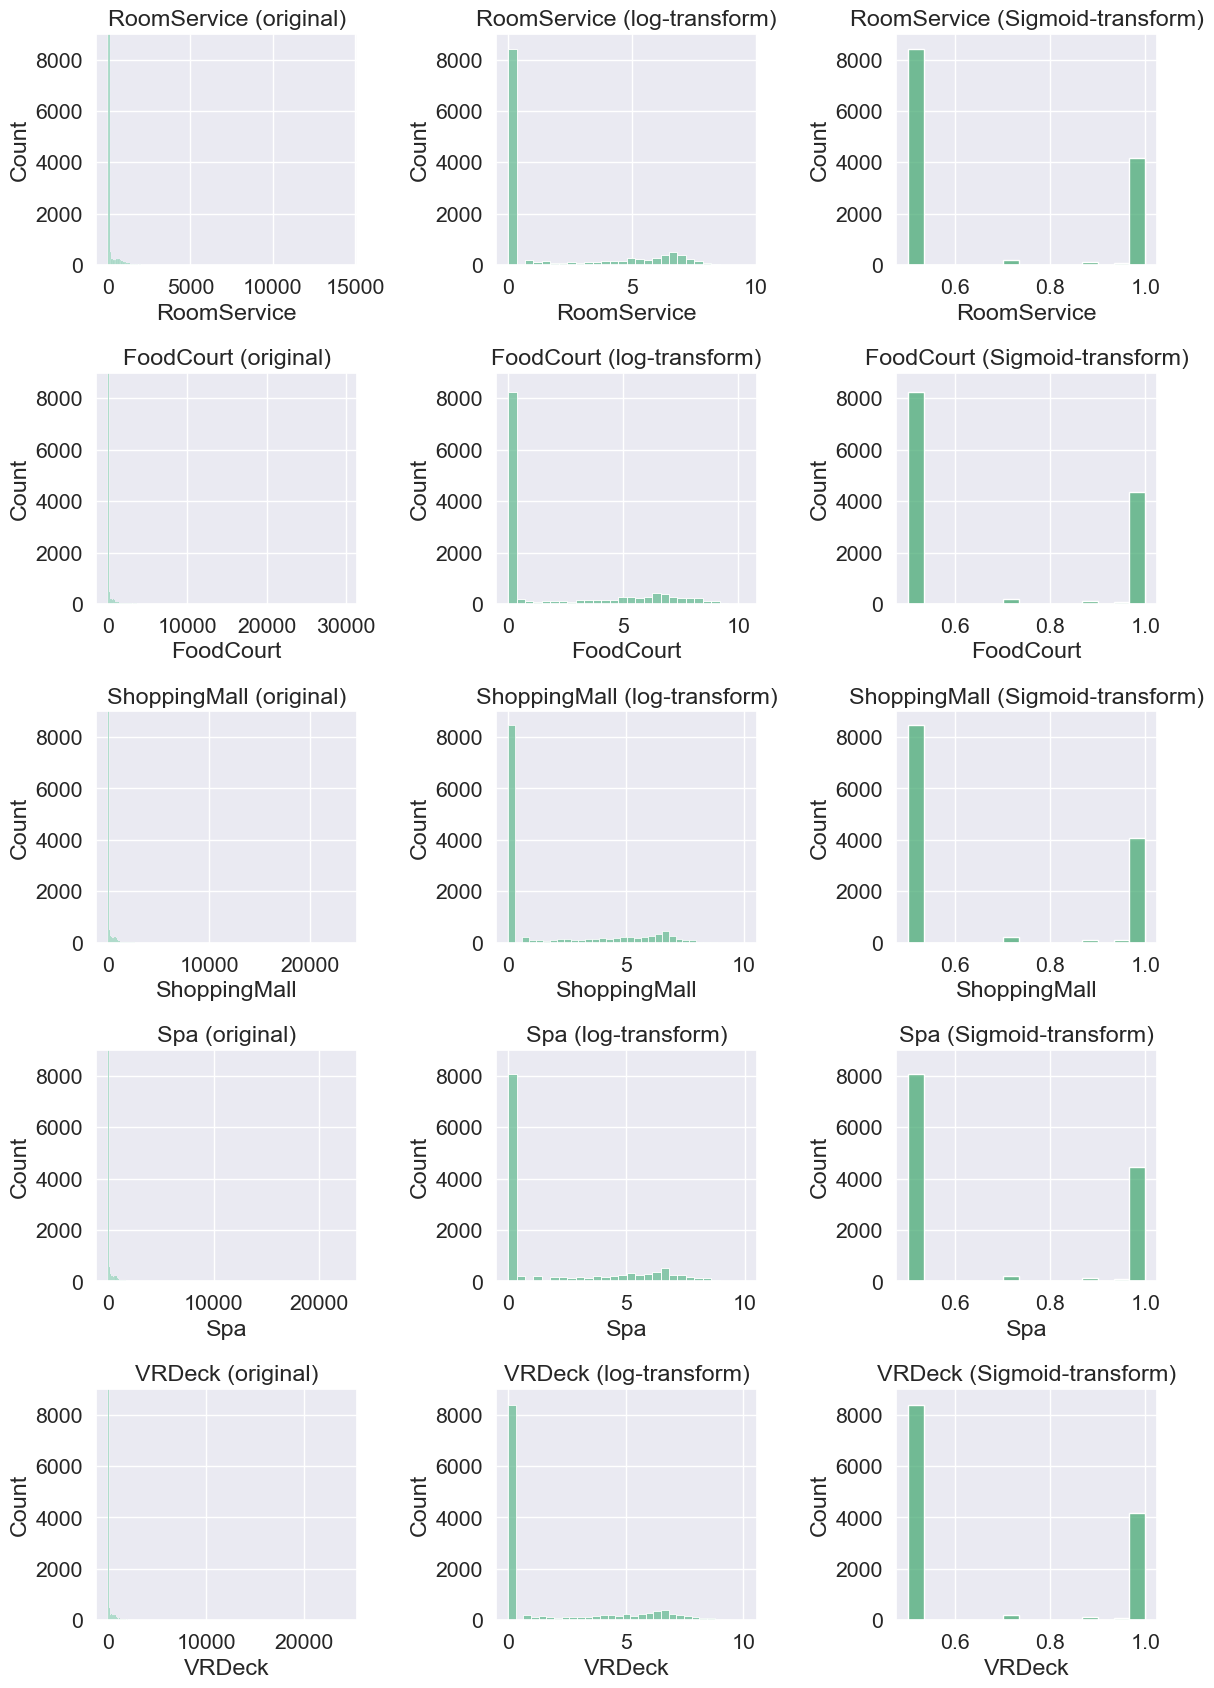

In [73]:
fig = plt.figure(figsize=(12,20))
for i, col in enumerate(Expenditure_features):
    plt.subplot(6,3,3*i+1)
    sns.histplot(data[col], binwidth=100)
    plt.ylim([0,9000])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,3,3*i+2)
    sns.histplot(np.log(1+data[col]), color='C1')
    plt.ylim([0,9000])
    plt.title(f'{col} (log-transform)')

    plt.subplot(6,3,3*i+3)
    sns.histplot(1/(1+np.exp(-data[col])), color='C2')
    plt.ylim([0,9000])
    plt.title(f'{col} (Sigmoid-transform)')
    
fig.tight_layout()

可以看出，如果使用sigmoid变换，虽然数值成功归一化了，但是无法体现出太大的差异性，不利于模型的学习，因此使用log变换

In [74]:
for col in Expenditure_features:
    data[col] = np.log(1+data[col])

In [75]:
data.to_csv("..\dataset\spaceship-titanic\\nomissing.csv", index=False)

Encoding

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Cabin         12970 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12970 non-null  float64
 6   VIP           12970 non-null  object 
 7   RoomService   12970 non-null  float64
 8   FoodCourt     12970 non-null  float64
 9   ShoppingMall  12970 non-null  float64
 10  Spa           12970 non-null  float64
 11  VRDeck        12970 non-null  float64
 12  Name          12970 non-null  object 
 13  Transported   8693 non-null   object 
 14  Age_group     12970 non-null  object 
 15  Cabin_Deck    12970 non-null  object 
 16  Cabin_Number  12970 non-null  object 
 17  Cabin_Side    12970 non-null  object 
 18  Group         12970 non-nu

In [77]:
for col in data.columns[data.dtypes == object]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
        
data['CryoSleep'] = data['CryoSleep'].astype('int')

In [78]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Cabin_Number,Cabin_Side,Group,Group_size,alone,LastName,FirstName,Family_size,Expenditure,spending
0,0,1,0,0,2,39.0,0,0.000000,0.000000,0.000000,...,0,0,1,1,1,1551,1708,4,0.0,0
1,1,0,0,0,2,24.0,0,4.700480,2.302585,3.258097,...,0,1,2,1,1,2289,1493,4,736.0,1
2,2,1,0,0,2,58.0,1,3.784190,8.182280,0.000000,...,0,1,3,2,0,2153,170,7,10383.0,1
3,3,1,0,0,2,33.0,0,0.000000,7.157735,5.918894,...,0,1,3,2,0,2153,2424,7,5176.0,1
4,4,0,0,0,2,16.0,0,5.717028,4.262680,5.023881,...,1,1,4,1,1,1924,2816,9,1091.0,1


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  int32  
 1   HomePlanet    12970 non-null  int32  
 2   CryoSleep     12970 non-null  int32  
 3   Cabin         12970 non-null  int32  
 4   Destination   12970 non-null  int32  
 5   Age           12970 non-null  float64
 6   VIP           12970 non-null  int32  
 7   RoomService   12970 non-null  float64
 8   FoodCourt     12970 non-null  float64
 9   ShoppingMall  12970 non-null  float64
 10  Spa           12970 non-null  float64
 11  VRDeck        12970 non-null  float64
 12  Name          12970 non-null  int32  
 13  Transported   12970 non-null  int32  
 14  Age_group     12970 non-null  int32  
 15  Cabin_Deck    12970 non-null  int32  
 16  Cabin_Number  12970 non-null  int32  
 17  Cabin_Side    12970 non-null  int32  
 18  Group         12970 non-nu

In [80]:
cor = data.corr()
cor = np.round(cor,3)
cor['Transported']

PassengerId     0.010
HomePlanet      0.057
CryoSleep       0.200
Cabin             NaN
Destination    -0.034
Age            -0.035
VIP            -0.032
RoomService    -0.146
FoodCourt      -0.059
ShoppingMall   -0.072
Spa            -0.156
VRDeck         -0.153
Name           -0.008
Transported     1.000
Age_group      -0.040
Cabin_Deck     -0.037
Cabin_Number   -0.011
Cabin_Side      0.039
Group           0.010
Group_size      0.025
alone          -0.051
LastName       -0.017
FirstName      -0.007
Family_size    -0.025
Expenditure    -0.086
spending       -0.200
Name: Transported, dtype: float64

In [81]:
fea_label = pd.DataFrame(cor['Transported'])
fea_label = fea_label.drop(index='Transported')
fea_label.sort_values(by='Transported',ascending=False)

,Transported
CryoSleep,0.200
HomePlanet,0.057
Cabin_Side,0.039
Group_size,0.025
PassengerId,0.010
Group,0.010
FirstName,-0.007
Name,-0.008
Cabin_Number,-0.011
LastName,-0.017


<AxesSubplot: >

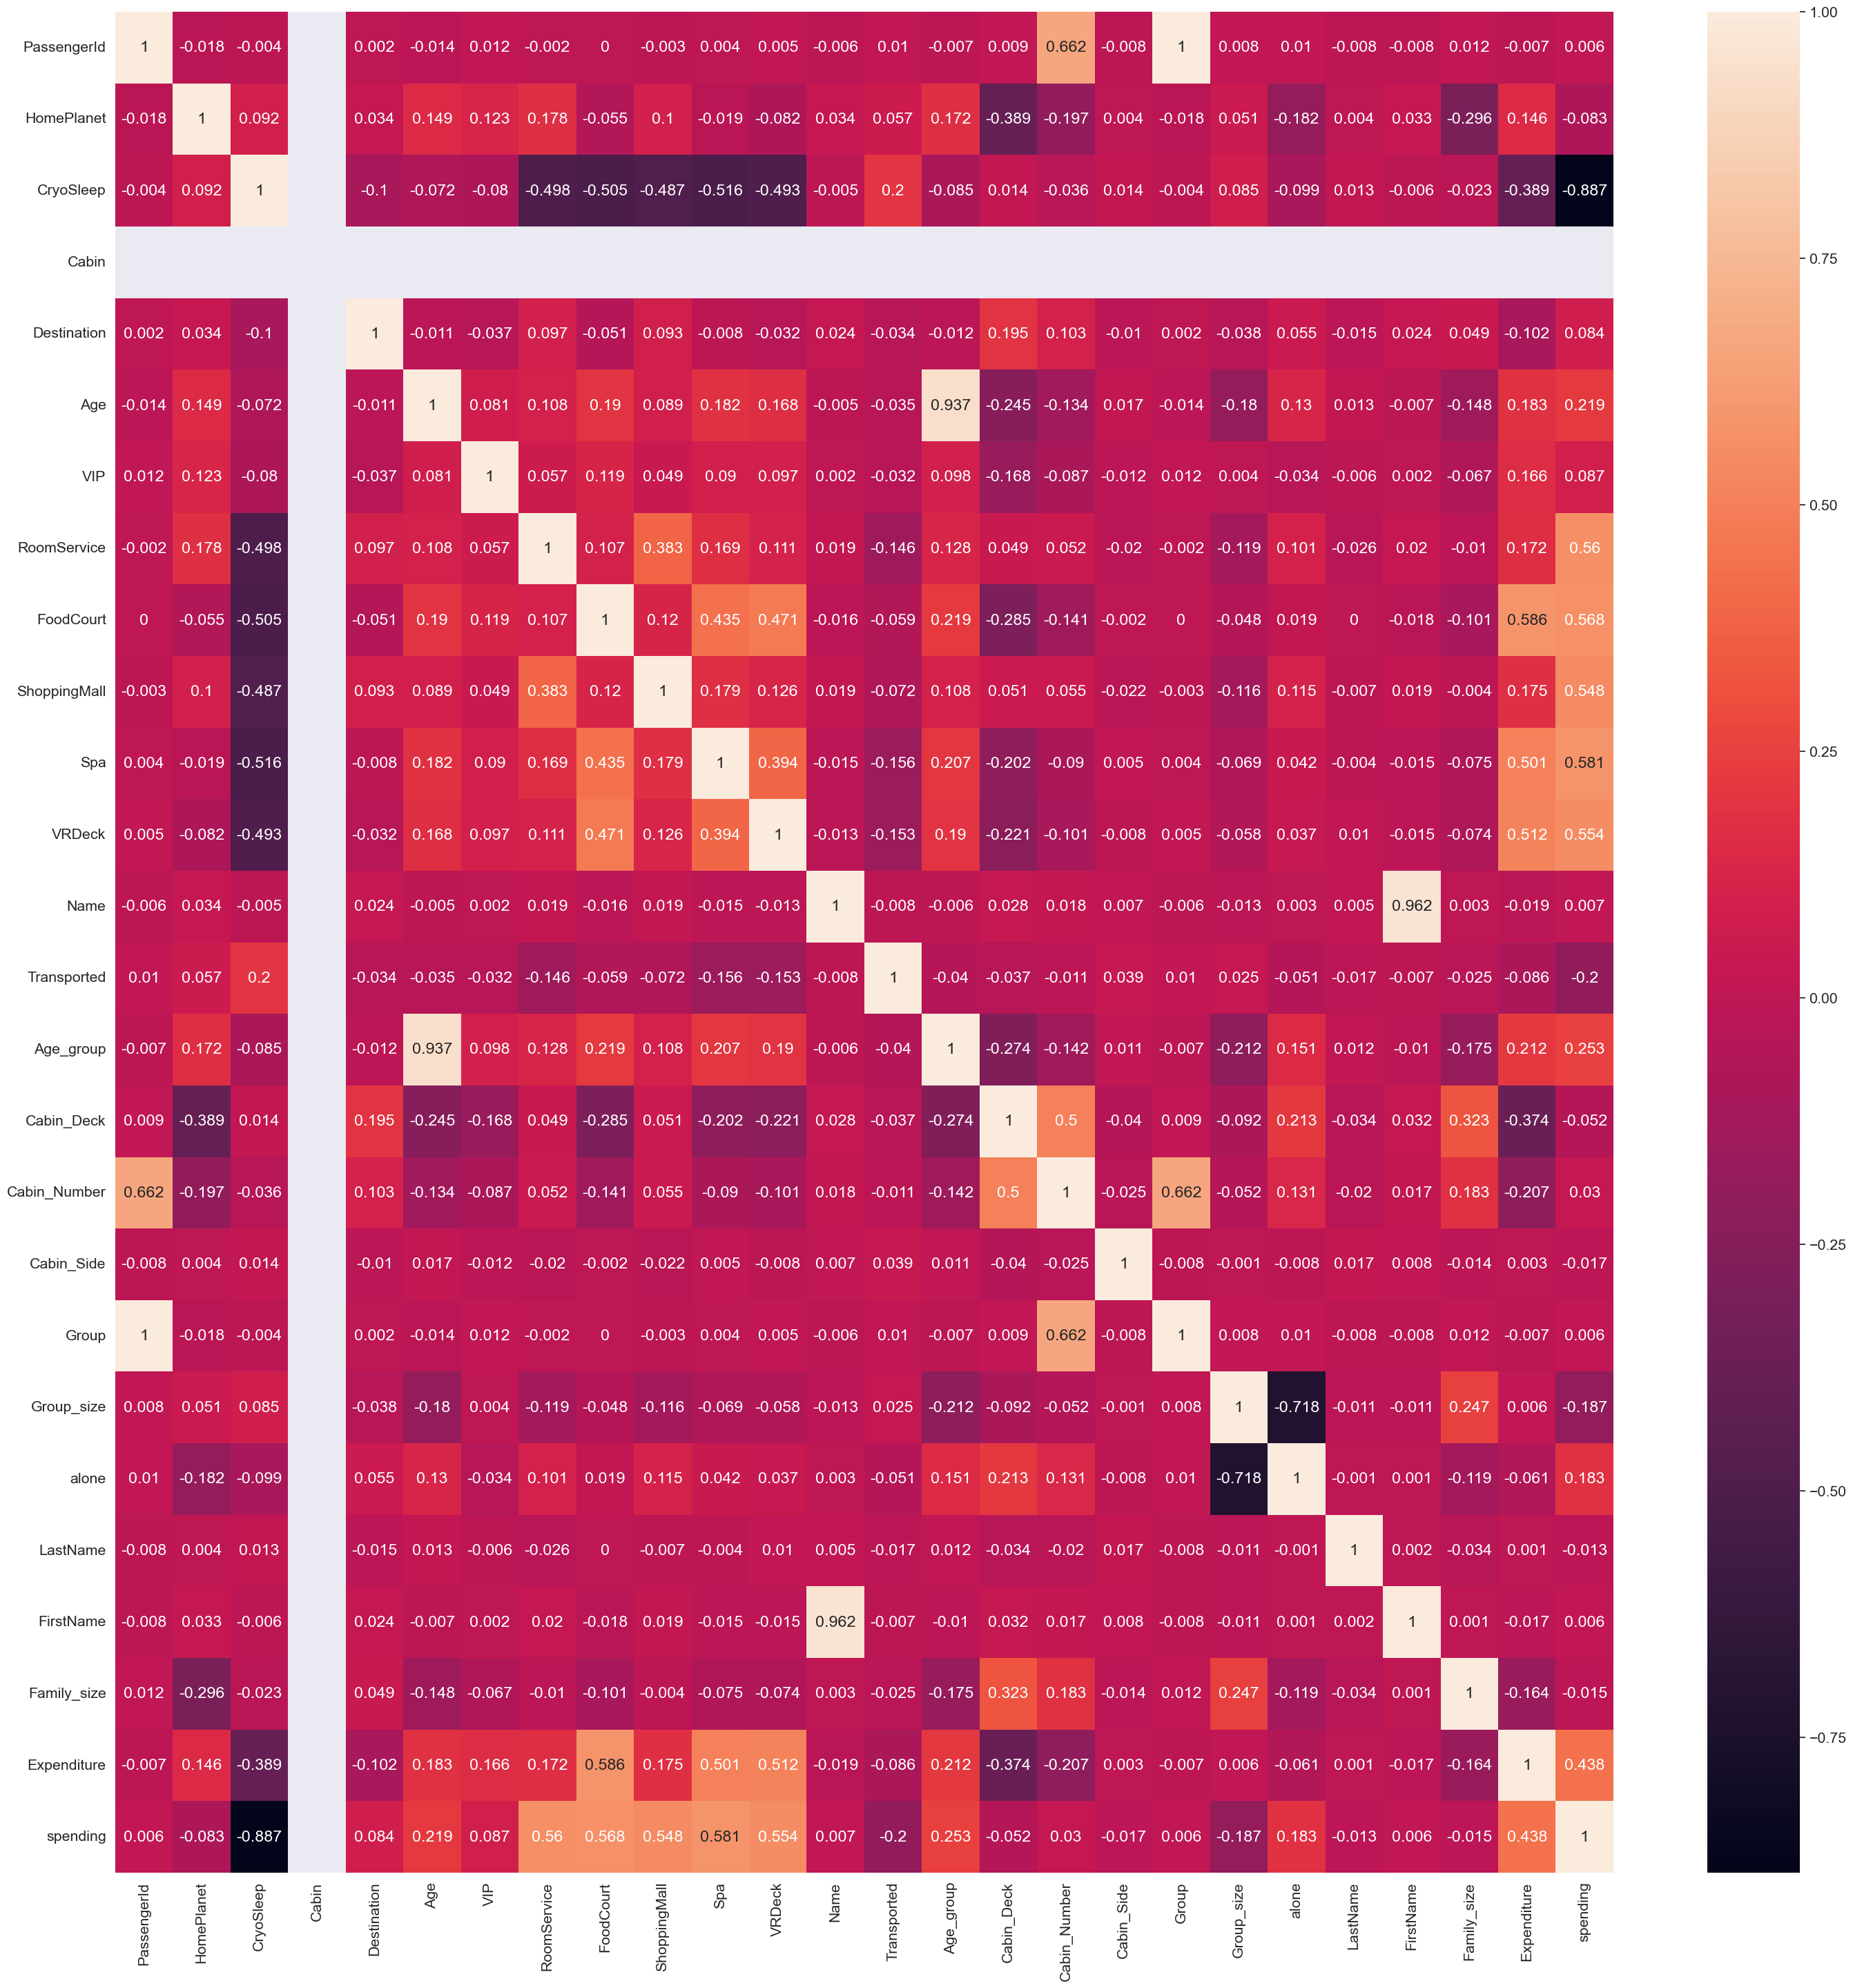

In [82]:
plt.figure(figsize=(35, 35))
sns.heatmap(cor, annot=True, fmt='g')

In [83]:
train, x_test = data.iloc[:train_set.shape[0]], data.iloc[train_set.shape[0]:].drop(['Transported'], axis=1)
x_train, y_train = train.drop(['Transported'], axis=1), train['Transported']
y_test = pd.read_csv('..\dataset\spaceship-titanic\\sample_submission.csv')

# X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=43, stratify=y_train)

In [84]:
# selector = SelectKBest(chi2)
# selector = selector.fit(x_train,y_train)
# Scores = selector.scores_#越高越好

# Score_dic = {}
# for i in range(0,len(Scores)):
#     Score_dic[i] = Scores[i] 
# Score_dic = sorted(Score_dic.items(),  key=lambda d: d[1], reverse=True)

# # Pvalues= selector.pvalues_#越低越好
# # Pvalue_dic = {}
# # for i in range(0,len(Pvalues)):
# #     Pvalue_dic[i] = Pvalues[i] 
# # Pvalue_dic = sorted(Pvalue_dic.items(),  key=lambda d: d[1], reverse=False)

In [85]:
# score = pd.DataFrame(Score_dic)
# score.rename(inplace = True, columns = {0: 'Feature',1:'Score'}, index = {0:14,1:12,2:8,3:5,4:9,5:7,6:1,7:15,8:6,9:3,10:0,11:10,12:16,13:13,14:2,15:11,16:4})
# for i in range(len(score['Feature'])):
#     j = score['Feature'][i]
#     k = 0
#     for m in data.keys():
#         if k == j:
#             score['Feature'][i] = m
#         k += 1
# for i in range(len(score['Score'])):
#     score['Score'][i] = round(score['Score'][i],3)
# score

Text(Age_51+, 1073, '1073')

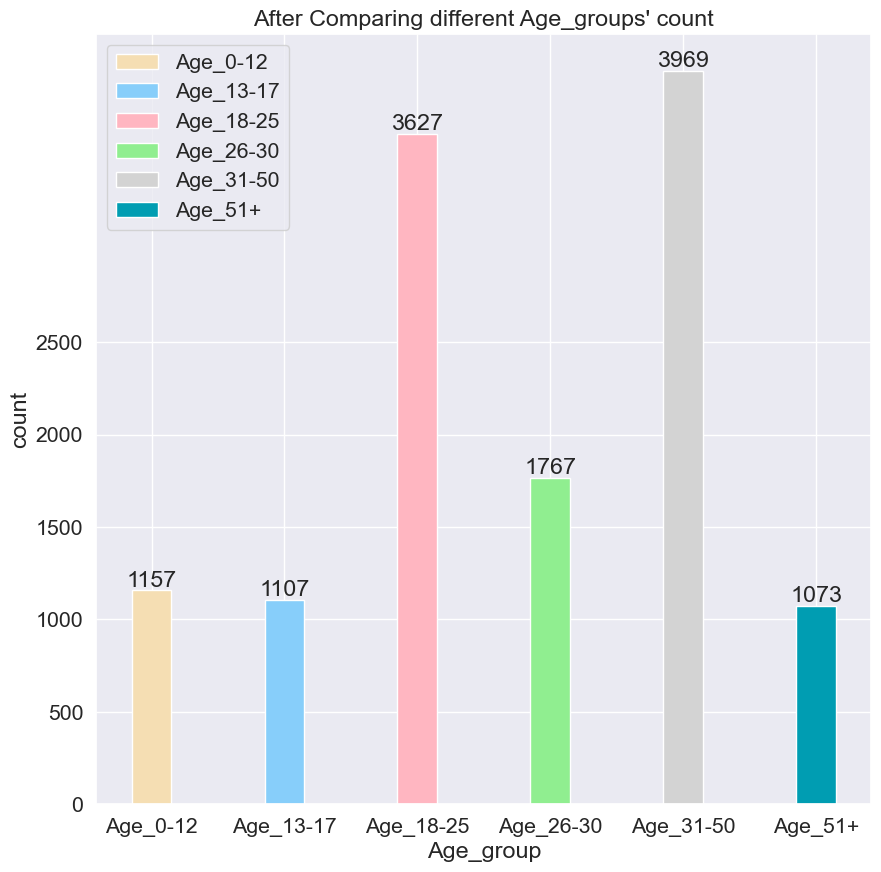

In [86]:
for i in range(0,12970):
    for j in Age_group.keys():
        if data['Age_group'][i] == j:
            Age_group[j] = Age_group[j] + 1

plt.figure(figsize=(10,10))
Age_group_bar_0 = plt.bar("Age_0-12", Age_group['Age_0-12'], width=0.3, color=['#F5DEB3'], label = "Age_0-12");
Age_group_bar_13  = plt.bar("Age_13-17", Age_group['Age_13-17'], width=0.3, color=['#87CEFA'], label = "Age_13-17");
Age_group_bar_18  = plt.bar("Age_18-25", Age_group['Age_18-25'], width=0.3, color=['#FFB6C1'], label = "Age_18-25");
Age_group_bar_26  = plt.bar("Age_26-30", Age_group['Age_26-30'], width=0.3, color=['#90EE90'], label = "Age_26-30");
Age_group_bar_31  = plt.bar("Age_31-50", Age_group['Age_31-50'], width=0.3, color=['#D3D3D3'], label = "Age_31-50");
Age_group_bar_51  = plt.bar("Age_51+", Age_group['Age_51+'], width=0.3, color=['#009db2'], label = "Age_51+");
plt.title("After Comparing different Age_groups' count")
plt.xlabel('Age_group')
plt.ylabel('count')
plt.yticks(range(0,3000,500))
plt.legend()

plt.text("Age_0-12", Age_group['Age_0-12'], Age_group['Age_0-12'], ha='center', va='bottom')
plt.text("Age_13-17", Age_group['Age_13-17'], Age_group['Age_13-17'], ha='center', va='bottom')
plt.text("Age_18-25", Age_group['Age_18-25'], Age_group['Age_18-25'], ha='center', va='bottom')
plt.text("Age_26-30", Age_group['Age_26-30'], Age_group['Age_26-30'], ha='center', va='bottom')
plt.text("Age_31-50", Age_group['Age_31-50'], Age_group['Age_31-50'], ha='center', va='bottom')
plt.text("Age_51+", Age_group['Age_51+'], Age_group['Age_51+'], ha='center', va='bottom')


In [87]:
data.drop(['PassengerId','Cabin','Name','Group_size','FirstName','LastName','Family_size'],axis=1, inplace=True)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  int32  
 1   CryoSleep     12970 non-null  int32  
 2   Destination   12970 non-null  int32  
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int32  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Transported   12970 non-null  int32  
 11  Age_group     12970 non-null  int32  
 12  Cabin_Deck    12970 non-null  int32  
 13  Cabin_Number  12970 non-null  int32  
 14  Cabin_Side    12970 non-null  int32  
 15  Group         12970 non-null  int32  
 16  alone         12970 non-null  int32  
 17  Expenditure   12970 non-null  float64
 18  spending      12970 non-nu

In [89]:
data.to_csv("..\dataset\spaceship-titanic\\encode.csv", index=False)

In [90]:
no_encode = pd.read_csv("..\dataset\spaceship-titanic\\nomissing.csv")

In [91]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score,plot_roc_curve

{ 1 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8057471264367816      Precision: 0.7915742793791575      Recall: 0.8263888888888888      F1-Score: 0.8086070215175539
{ 2 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8091954022988506      Precision: 0.8048245614035088      Recall: 0.8265765765765766      F1-Score: 0.8155555555555556
{ 3 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8103448275862069      Precision: 0.7990970654627539      Recall: 0.8232558139534883      F1-Score: 0.8109965635738831
{ 4 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.80897583429229      Precision: 0.8243559718969555      Recall: 0.7945823927765236      F1-Score: 0.8091954022988506
{ 5 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.7882623705408516      Precision: 0.7717391304347826      Recall: 0.8179723502304147      F1-Score: 0.7941834451901566
{ 6 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8032220943613348      Precision: 0.8247663551401869      Recall: 0.7861915367483296      F1-Score: 0.8050171037628279
{ 7 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.807825086306099      Precision: 0.8088888888888889      Recall: 0.8179775280898877      F1-Score: 0.8134078212290503
{ 8 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8296892980437284      Precision: 0.8280542986425339      Recall: 0.8356164383561644      F1-Score: 0.8318181818181819
{ 9 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8227848101265823      Precision: 0.8135198135198135      Recall: 0.8250591016548463      F1-Score: 0.8192488262910798
{ 10 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.810126582278481      Precision: 0.8035320088300221      Recall: 0.8272727272727273      F1-Score: 0.8152295632698767
Mean_Accuracy: 0.8096173432271205      Mean_Precision: 0.8070352373598604      Mean_Recall: 0.8180893354547848      Mean_F1-Score: 0.8123259484507017      Time: 14.911982774734497


d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


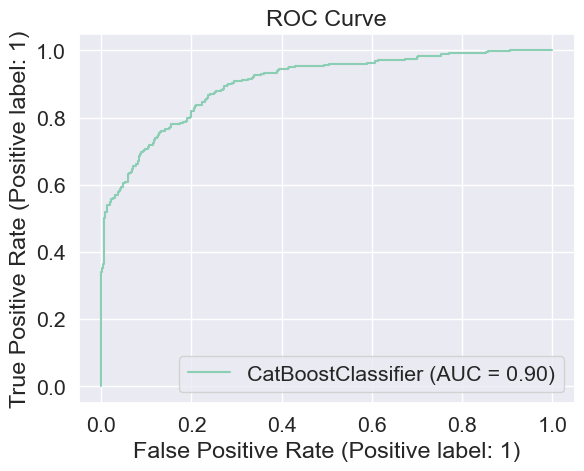

In [92]:
classifier = CatBoostClassifier(random_state=0, verbose=False, learning_rate=0.05, max_depth=8, n_estimators=200)
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: CatBoost     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_cb = time_end - time_start
c_m_cb = np.round(cm / 10).astype(int)
acc_cb = np.mean(accs)
pre_cb = np.mean(pres)
rec_cb = np.mean(recs)
f1_cb = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:",time_cb)

<AxesSubplot: >

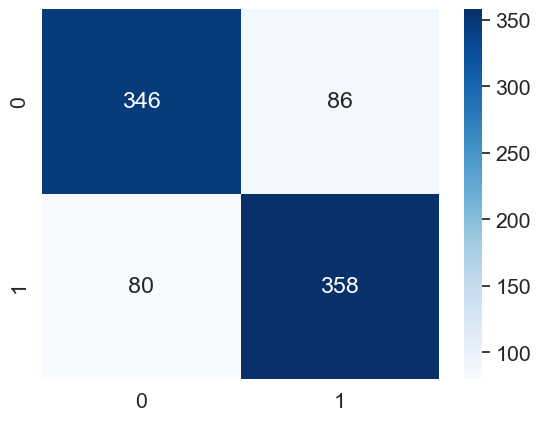

In [93]:
sns.heatmap(c_m_cb, annot=True, cmap='Blues', fmt='g')

d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


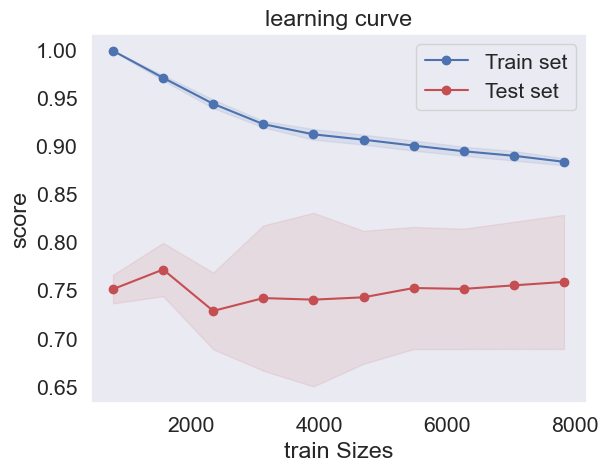

In [94]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")